# Terzo Homework - Big Data Engineering

## Import delle librerie Python utili

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

## Check dei dati in input

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/yelp-dataset/Dataset_User_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json


## Installazione di PySpark

### Caricamento delle librerie

In [3]:
# installazione di Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download spark3.0.0
!wget -q http://apache.osuosl.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

# estrazione dello zip
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

# installazione findspark 
!pip install -q findspark

# installazione di Spark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 KB 13.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=117ddcc2bfba28e4c072cb34bcf68d600df49c1a0e409620230cf688a27f9ee5
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.5
    Uninstalling py4j-0.10.9.5:
      Successfully uninstalled py4j-0.10.9.5


### Controllo variabili d'ambiente

In [4]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/kaggle/working/spark-3.2.1-bin-hadoop3.2"

### Inizializzazione di Spark

In [5]:
import findspark
findspark.init()

from pyspark.context import SparkContext
sc = SparkContext.getOrCreate()

assert  "3." in sc.version, "Verify that the cluster Spark's version is 3.x"

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/20 17:51:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Controllo della versione

In [6]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

## Import di SparkSQL

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, col, abs, split, explode
from pyspark.sql import functions as F
spark = SparkSession.builder.appName('homework3_bde').getOrCreate()

## Caricamento dei file su Spark

In [8]:
#import yelp review data into dataframe
yelp_review = spark.read.json('../input/yelp-dataset/yelp_academic_dataset_review.json')
# import yelp business data into dataframe
yelp_business = spark.read.json('../input/yelp-dataset/yelp_academic_dataset_business.json')
# import yelp user data into dataframe
yelp_user = spark.read.json('../input/yelp-dataset/yelp_academic_dataset_user.json')
# import yelp tip data into dataframe
#yelp_tip = spark.read.json('../input/yelp_academic_dataset_tip.json')
# import yelp checkin data into dataframe
#yelp_checkin = spark.read.json('../input/yelp_academic_dataset_checkin.json')

22/05/20 17:52:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Query effettuate

### Top 10 Business per numero di recensioni

In [10]:
rec_tre_stelle = yelp_review.filter('stars >3')
rec_group = rec_tre_stelle.groupby('business_id').count()
rec_sort = rec_group.sort('count',ascending=False)

business = yelp_business.select('business_id','name','categories')
rec_join_buss = business.join(rec_sort,'business_id','inner')
rec_join_sort = rec_join_buss.sort('count', ascending=False)
top10_buss_per_rec = rec_join_sort.limit(10)
top10_buss_per_rec.show()

+--------------------+--------------------+--------------------+-----+
|         business_id|                name|          categories|count|
+--------------------+--------------------+--------------------+-----+
|_ab50qdWOk0DdB6XO...|   Acme Oyster House|Live/Raw Food, Se...| 5982|
|ac1AeYqs8Z4_e2X5M...|        Oceana Grill|Restaurants, Seaf...| 5865|
|GXFMD0Z4jEVZBCsbP...|Hattie B’s Hot Ch...|American (Traditi...| 5425|
|ytynqOUb3hjKeJfRj...|Reading Terminal ...|Candy Stores, Sho...| 5380|
|oBNrLz4EDhiscSlbO...|Ruby Slipper - Ne...|Restaurants, Amer...| 4369|
|_C7QiQQc47AOEv4PE...|  Commander's Palace|French, Restauran...| 4008|
|GBTPC53ZrG1ZBY3DT...|                Luke|German, Restauran...| 3726|
|I_3LMZ_1m2mzR0oLI...|  Pappy's Smokehouse|Food, Restaurants...| 3575|
|6a4gLLFSgr-Q6CZXD...|              Cochon|Cajun/Creole, Sea...| 3567|
|gTC8IQ_i8zXytWSly...|      Cochon Butcher|Shopping, Butcher...| 3538|
+--------------------+--------------------+--------------------+-----+



In [11]:
yelp_business.select('business_id','name','city','state','categories').show(5)

+--------------------+--------------------+-------------+-----+--------------------+
|         business_id|                name|         city|state|          categories|
+--------------------+--------------------+-------------+-----+--------------------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|Santa Barbara|   CA|Doctors, Traditio...|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|       Affton|   MO|Shipping Centers,...|
|tUFrWirKiKi_TAnsV...|              Target|       Tucson|   AZ|Department Stores...|
|MTSW4McQd7CbVtyjq...|  St Honore Pastries| Philadelphia|   PA|Restaurants, Food...|
|mWMc6_wTdE0EUBKIG...|Perkiomen Valley ...|   Green Lane|   PA|Brewpubs, Breweri...|
+--------------------+--------------------+-------------+-----+--------------------+
only showing top 5 rows



In [13]:
buss_cat_split = yelp_business.select('business_id','categories').withColumn("categories", explode(split("categories", ", ")))
buss_cat_split.show(10)

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|Pns2l4eNsfO8kk83d...|             Doctors|
|Pns2l4eNsfO8kk83d...|Traditional Chine...|
|Pns2l4eNsfO8kk83d...|Naturopathic/Holi...|
|Pns2l4eNsfO8kk83d...|         Acupuncture|
|Pns2l4eNsfO8kk83d...|    Health & Medical|
|Pns2l4eNsfO8kk83d...|       Nutritionists|
|mpf3x-BjTdTEA3yCZ...|    Shipping Centers|
|mpf3x-BjTdTEA3yCZ...|      Local Services|
|mpf3x-BjTdTEA3yCZ...|            Notaries|
|mpf3x-BjTdTEA3yCZ...|     Mailbox Centers|
+--------------------+--------------------+
only showing top 10 rows



In [14]:
conteggio_categorie = yelp_business.select('business_id','categories').withColumn("categories", explode(split("categories", ", "))).select('categories').distinct().count()
print(f'Numero di categorie univoche: {conteggio_categorie}')

Numero di categorie univoche: 1311


In [16]:
buss_cat = yelp_business.select('business_id','categories').withColumn("categories", explode(split("categories", ", ")))
buss_cat.groupBy('categories').count().show()

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|      Dermatologists|  336|
|    Historical Tours|  136|
|      Paddleboarding|   98|
|    Hot Air Balloons|   12|
| Mobile Home Dealers|    8|
|             Beaches|  122|
|     Pet Photography|   22|
|       Skating Rinks|  111|
|       Data Recovery|  121|
|        Aerial Tours|   12|
|         Boat Repair|   78|
|              Fondue|   27|
|       Videographers|   73|
|   Pet Waste Removal|   10|
|Faith-based Crisi...|    1|
|         Hobby Shops|  552|
|            Day Spas| 1997|
|            Honduran|   24|
|               Reiki|  201|
|       Nephrologists|    2|
+--------------------+-----+
only showing top 20 rows



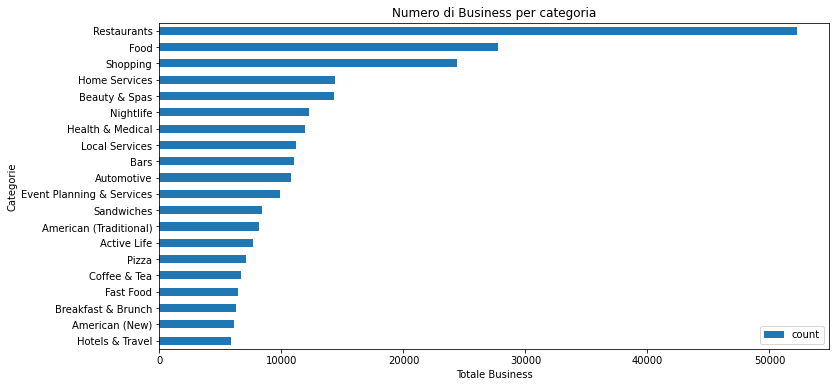

<Figure size 1440x360 with 0 Axes>

In [36]:
buss_cat_count = buss_cat.groupBy('categories').count()
top20_buss_cat_count = buss_cat_count.sort("count", ascending=False).limit(20)

top20_buss_cat_pandas = top20_buss_cat_count.toPandas().set_index('categories')

# grafico del numero di locali per ogni categoria
top20_buss_cat_pandas.plot.barh(figsize=(12,6)).invert_yaxis()
plt.title('Numero di Business per categoria')
plt.xlabel("Totale Business")
plt.ylabel("Categorie")
plt.show()
plt.savefig('num_business_per_cat.png')

## Query 2
Ora voglio vedere quanto le stelle che sono segnate nel business si discostano dalla media delle stelle di quel business calcolata facendo la media delle review

In [21]:
yelp_business = yelp_business.withColumnRenamed('stars',"business_stars")
yelp_review = yelp_review.withColumnRenamed('stars',"review_stars")

In [22]:
buss_join_rev = yelp_business.join(yelp_review, on=['business_id'], how='inner')

buss_join_rev_join_user = yelp_user.join(buss_join_rev, on=['user_id'], how='inner')

buss_join_rev_join_user.select('business_id','business_stars','review_stars','user_id','elite').sort('business_id','user_id').filter(buss_join_rev_join_user['elite'] != '').show(10)


+--------------------+--------------+------------+--------------------+--------------------+
|         business_id|business_stars|review_stars|             user_id|               elite|
+--------------------+--------------+------------+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|           4.5|         4.0|i48cHEyRBl5g9_npY...|     2019,20,20,2021|
|---kPU91CF4Lq2-Wl...|           4.5|         5.0|qrCkKrEwQ-q9m1iWS...|2018,2019,20,20,2021|
|--0iUa4sNDFiZFrAd...|           3.0|         1.0|Dr-atSrDQURhT9GiH...|           2014,2015|
|--0iUa4sNDFiZFrAd...|           3.0|         4.0|j_orXueAYJBft-VUN...|2012,2013,2014,20...|
|--0iUa4sNDFiZFrAd...|           3.0|         3.0|mswloq-IjRr9yXLhB...|2011,2012,2013,20...|
|--0iUa4sNDFiZFrAd...|           3.0|         4.0|xbJlnyVkxuQq5jsG9...|2015,2016,2017,20...|
|--7PUidqRWpRSpXeb...|           2.0|         2.0|3YhG4h4Ok654iVfqd...|2013,2014,2015,20...|
|--7PUidqRWpRSpXeb...|           2.0|         1.0|5IY6Kb6BqNINb0oc1...

In [23]:
buss_join_rev_join_user = buss_join_rev_join_user.withColumn('RevStar_BussStar_diff',(abs((buss_join_rev_join_user['review_stars']-buss_join_rev_join_user['business_stars'])*-1)/buss_join_rev_join_user['business_stars'])*100)
buss_join_rev_join_user = buss_join_rev_join_user.select('business_id','business_stars','review_stars','RevStar_BussStar_diff','user_id','elite').sort('business_id').filter(buss_join_rev_join_user.elite!='')
buss_join_rev_join_user.show(10)

+--------------------+--------------+------------+---------------------+--------------------+--------------------+
|         business_id|business_stars|review_stars|RevStar_BussStar_diff|             user_id|               elite|
+--------------------+--------------+------------+---------------------+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|           4.5|         5.0|    11.11111111111111|qrCkKrEwQ-q9m1iWS...|2018,2019,20,20,2021|
|---kPU91CF4Lq2-Wl...|           4.5|         4.0|    11.11111111111111|i48cHEyRBl5g9_npY...|     2019,20,20,2021|
|--0iUa4sNDFiZFrAd...|           3.0|         4.0|    33.33333333333333|j_orXueAYJBft-VUN...|2012,2013,2014,20...|
|--0iUa4sNDFiZFrAd...|           3.0|         3.0|                  0.0|mswloq-IjRr9yXLhB...|2011,2012,2013,20...|
|--0iUa4sNDFiZFrAd...|           3.0|         4.0|    33.33333333333333|xbJlnyVkxuQq5jsG9...|2015,2016,2017,20...|
|--0iUa4sNDFiZFrAd...|           3.0|         1.0|    66.66666666666666|Dr-atSrD

In [24]:
buss_join_rev_join_user.describe(['RevStar_BussStar_diff']).show()
plot_bus_rev_user = buss_join_rev_join_user.select('RevStar_BussStar_diff').toPandas()

+-------+---------------------+
|summary|RevStar_BussStar_diff|
+-------+---------------------+
|  count|              1725658|
|   mean|   22.276995715835657|
| stddev|   21.647296352502718|
|    min|                  0.0|
|    max|                400.0|
+-------+---------------------+



In [32]:
plot_bus_rev_user

,RevStar_BussStar_diff
0,11.111111
1,11.111111
2,66.666667
3,33.333333
4,33.333333
...,...
1725653,14.285714
1725654,14.285714
1725655,14.285714
1725656,42.857143


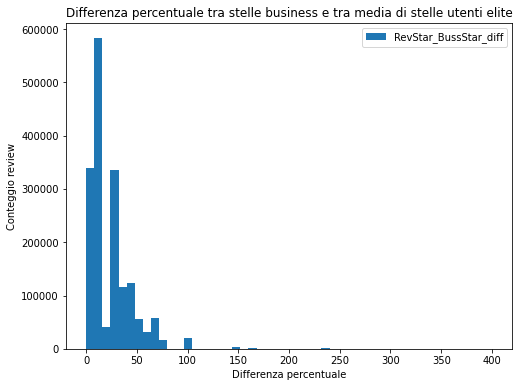

<Figure size 1440x360 with 0 Axes>

In [35]:
plot_bus_rev_user.plot.hist(bins=50, figsize=(8,6))
plt.xlabel('Differenza percentuale')
plt.ylabel('Conteggio review')
plt.title('Differenza percentuale tra stelle business e tra media di stelle utenti elite')
plt.show()
plt.savefig('Diff_perc_busStars_EliteStars.png')

In [38]:
tot = buss_join_rev_join_user.count()

inf_25 = buss_join_rev_join_user.filter(buss_join_rev_join_user['RevStar_BussStar_diff'] <= 25).count()
print(f'Differenza percentuale inferiore al 25%: {inf_25}, Percentuale: {(inf_25/tot)*100}%')

da_25_a_50 = buss_join_rev_join_user.filter(buss_join_rev_join_user['RevStar_BussStar_diff'] > 25).filter(buss_join_rev_join_user['RevStar_BussStar_diff'] <= 50).count()
print(f'Differenza percentuale tra il 25% e il 50%: {da_25_a_50}, Percentuale: {(da_25_a_50/tot)*100}%')

da_50_a_75 = buss_join_rev_join_user.filter(buss_join_rev_join_user['RevStar_BussStar_diff'] > 50).filter(buss_join_rev_join_user['RevStar_BussStar_diff'] <= 75).count()
print(f'Differenza percentuale tra il 50% e il 75%: {da_50_a_75}, Percentuale: {(da_50_a_75/tot)*100}%')

da_75_a_100 = buss_join_rev_join_user.filter(buss_join_rev_join_user['RevStar_BussStar_diff'] > 75).filter(buss_join_rev_join_user['RevStar_BussStar_diff'] <= 100).count()
print(f'Differenza percentuale tra il 75% e il 100%: {da_75_a_100}, Percentuale: {(da_75_a_100/tot)*100}%')

sup_100 = buss_join_rev_join_user.filter(buss_join_rev_join_user['RevStar_BussStar_diff'] > 100).count()
print(f'Differenza percentuale superiore al 100%: {sup_100}, Percentuale: {(sup_100/tot)*100}%')

Differenza percentuale inferiore al 25%: 1299274, Percentuale: 75.29151199136793%


Differenza percentuale tra il 25% e il 50%: 285261, Percentuale: 16.53056399356072%


Differenza percentuale tra il 50% e il 75%: 110822, Percentuale: 6.422014095492849%


Differenza percentuale tra il 75% e il 100%: 24332, Percentuale: 1.4100128762477848%


Differenza percentuale superiore al 100%: 5969, Percentuale: 0.3458970433307179%


In [39]:
df_percentuali = spark.createDataFrame(
    [
        ('[0%,25%]', (inf_25/tot)*100), 
        ('(25%,50%]', (da_25_a_50/tot)*100),
        ('(50%,75%]', (da_50_a_75/tot)*100),
        ('(75%,100%]', (da_75_a_100/tot)*100),
        ('(100%,∞)', (sup_100/tot)*100),
    ],
    ['Range', 'Percentuale'] 
)

df_percentuali.show()

+----------+------------------+
|     Range|       Percentuale|
+----------+------------------+
|  [0%,25%]| 75.29151199136793|
| (25%,50%]| 16.53056399356072|
| (50%,75%]| 6.422014095492849|
|(75%,100%]|1.4100128762477848|
|  (100%,∞)|0.3458970433307179|
+----------+------------------+



In [41]:
perc_pandas = df_percentuali.toPandas()
perc_pandas = perc_pandas.set_index('Range')

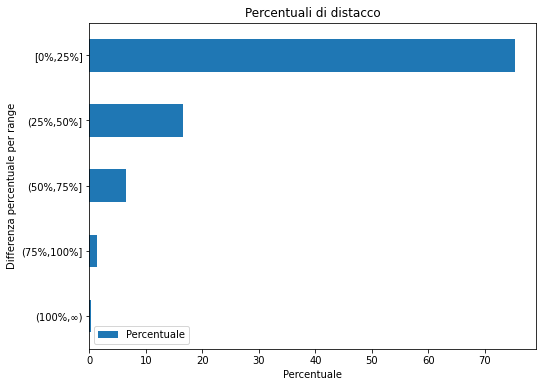

In [43]:
perc_pandas.plot.barh(figsize=(8,6)).invert_yaxis()
plt.title('Percentuali di distacco')
plt.xlabel('Percentuale')
plt.ylabel('Differenza percentuale per range')
plt.xticks()
plt.yticks()
plt.show()

# qua cominciano le cose di ML

In [ ]:
yelp_review.join(yelp_business, 'business_id', 'inner').filter("name=='Luke'").show(5)

In [ ]:
luke_rev = yelp_review.join(yelp_business, 'business_id', 'inner').filter("name=='Luke'").select('business_id', 'name', 'review_stars','date')

In [ ]:
luke_rev.printSchema()

## Machine Learning

In [44]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
luke_rev_clean = luke_rev.select('review_stars','date')
#(trainingData, testData) = luke_rev_clean.randomSplit([0.7, 0.3])



col = luke_rev_clean.columns
featureIndexer =VectorIndexer(inputCol='date', outputCol="indexedFeatures", maxCategories=4).fit(luke_rev_clean)
(trainingData, testData) = luke_rev_clean.randomSplit([0.7, 0.3])

trainingData.show(5)

#ass = VectorAssembler(inputCols=col, outputCol="features")
#luke_df = ass.transform(luke_rev_clean)

#luke_.show(5)

In [ ]:
model = RandomForest.trainRegressor(RDD_train, categoricalFeaturesInfo={},
                                    numTrees=3, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=4, maxBins=32)

In [ ]:
Ldf = luke_rev_clean.sort("date", ascending=True)



luke_rev_clean_pandas = Ldf.toPandas()
luke_rev_clean_pandas.plot.bar()
plt.show()

In [ ]:
prova = review_business_name.sort("count", ascending=True)
prova = prova.filter("count>300")
prova.show(50)

In [ ]:
from pyspark.sql.functions import expr

stil_rev = yelp_review.join(yelp_business, 'business_id', 'inner').filter("name=='The STIL'").select('review_stars','date')
stil_rev = stil_rev.sort("date", ascending=True)
stil_rev.printSchema()
#stil_rev = stil_rev.withColumn("date", "date".cast(StringType))

import datetime
#stil_rev = stil_rev.withColumn("date", expr("CAST(order AS DATE)"))
# stil_rev = stil_rev.withColumn("date", expr(col("date").strftime("%Y%m%d%H%M%S")))

#stil_rev = stil_rev.withColumn("date", col("date").timestamp())

#stil_rev = stil_rev.withColumn("date", stil_rev.date.strftime("%Y%m%d%H%M%S"))

In [ ]:
datecol = stil_rev.select('date')
datecol = datecol.toPandas()

print(type(datecol['date'][0]))

from datetime import datetime

for elem in datecol:
    elem = datetime.strftime(elem, '%y-%m-%d %H:%M:%S')

datecol.head()

In [ ]:
col = stil_rev.columns
#featureIndexer =VectorIndexer(inputCol='date', outputCol="indexedFeatures", maxCategories=4).fit(stil_rev)

ass = VectorAssembler(inputCols=col, outputCol="features")
stil_df = ass.transform(stil_rev)


In [ ]:
import datetime 
classcurrent_date= datetime.datetime.now() 

print("Original date and time object:", current_date) 
print("Date and Time in Integer Format:", int(current_date.strftime("%Y%m%d%H%M%S")))

## Voglio vedere gli utenti

In [45]:
#yelp_user.show(5)


user_class = (F.when(F.col('useful')/F.col('review_count') > 5, "good").otherwise("bad"))


prova = yelp_user.withColumn("goodness", user_class)
prova.select('average_stars', 'review_count', 'useful', 'name', 'goodness').show(5)

prova = prova.drop('yelping_since', 'user_id', 'name', 'friends', 'elite', 'compliment_funny')

prova.show(5)

+-------------+------------+------+------+--------+
|average_stars|review_count|useful|  name|goodness|
+-------------+------------+------+------+--------+
|         3.91|         585|  7217|Walker|    good|
|         3.74|        4333| 43091|Daniel|    good|
|         3.32|         665|  2086| Steph|     bad|
|         4.27|         224|   512|  Gwen|     bad|
|         3.54|          79|    29| Karen|     bad|
+-------------+------------+------+------+--------+
only showing top 5 rows

+-------------+---------------+---------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+----+-----+------------+------+--------+
|average_stars|compliment_cool|compliment_cute|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|fans|funny|review_count|useful|goodness|
+-------------+---------------+---------------+--

In [46]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

columns = prova.columns
columns.remove('goodness')
ass = VectorAssembler(inputCols=columns, outputCol="features")
df = ass.transform(prova)

In [47]:
stringIndexer = StringIndexer(inputCol="goodness", outputCol="label")
si_model = stringIndexer.fit(df)
df = si_model.transform(df)
df.show(5)

+-------------+---------------+---------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+----+-----+------------+------+--------+--------------------+-----+
|average_stars|compliment_cool|compliment_cute|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|fans|funny|review_count|useful|goodness|            features|label|
+-------------+---------------+---------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+----+-----+------------+------+--------+--------------------+-----+
|         3.91|            467|             56|           250|             18|             65|            232|              180|             844|                55|              239| 5994| 267| 1259|         585|  7217|    good|[3.9

## Addestramento

In [48]:
from pyspark.ml.classification import LinearSVC
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train = df.sampleBy("label", fractions={0: 0.7, 1: 0.7}, seed=10)
test = df.subtract(train)

lsvc = LinearSVC(maxIter=10, regParam=0.1)

lsvcModel = lsvc.fit(train)


pred = lsvcModel.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator.evaluate(pred)
print("Accuracy: %g" % (acc))

Accuracy: 0.982835


## Altra cosa di ML

In [49]:
user_filtrati = yelp_user.select('compliment_cool', 'compliment_cute', 'compliment_hot', 'compliment_note', 'compliment_writer', 'compliment_profile', 'review_count')
#user_filtrati.show(20)

prova2 = user_filtrati.withColumn('conto', (F.col('compliment_cool')+ F.col('compliment_cute')+F.col('compliment_hot')+F.col('compliment_note') + F.col('compliment_writer')+ F.col('compliment_profile'))/F.col('review_count'))
prova2.show(50)

prova3 = prova2.filter(F.col('conto') > 0.0).groupBy().avg('conto')
prova3.show()

+---------------+---------------+--------------+---------------+-----------------+------------------+------------+--------------------+
|compliment_cool|compliment_cute|compliment_hot|compliment_note|compliment_writer|compliment_profile|review_count|               conto|
+---------------+---------------+--------------+---------------+-----------------+------------------+------------+--------------------+
|            467|             56|           250|            232|              239|                55|         585|  2.2205128205128206|
|           3131|            157|          1145|           1847|             1521|               184|        4333|  1.8428340641587815|
|            119|             17|            89|             66|               35|                10|         665|  0.5052631578947369|
|             26|              6|            24|             12|               10|                 1|         224| 0.35267857142857145|
|              0|              0|             1|

+------------------+
|        avg(conto)|
+------------------+
|0.2213330822844841|
+------------------+



In [51]:
compliment_class = (F.when((F.col('compliment_cool')+ F.col('compliment_cute')+F.col('compliment_hot')+F.col('compliment_note') + F.col('compliment_writer')+ F.col('compliment_profile'))/F.col('review_count') > 0.3, "Trust").otherwise("Untrust"))

user_filtrati = user_filtrati.withColumn("complimentClass", compliment_class)
user_filtrati.show(50)



+---------------+---------------+--------------+---------------+-----------------+------------------+------------+---------------+
|compliment_cool|compliment_cute|compliment_hot|compliment_note|compliment_writer|compliment_profile|review_count|complimentClass|
+---------------+---------------+--------------+---------------+-----------------+------------------+------------+---------------+
|            467|             56|           250|            232|              239|                55|         585|          Trust|
|           3131|            157|          1145|           1847|             1521|               184|        4333|          Trust|
|            119|             17|            89|             66|               35|                10|         665|          Trust|
|             26|              6|            24|             12|               10|                 1|         224|          Trust|
|              0|              0|             1|              1|                0| 

In [52]:
columns2 = user_filtrati.columns
columns2.remove('complimentClass')
ass2 = VectorAssembler(inputCols=columns2, outputCol="features")
df2 = ass2.transform(user_filtrati)

stringIndexer2 = StringIndexer(inputCol="complimentClass", outputCol="label")
si_model2 = stringIndexer2.fit(df2)
df2 = si_model2.transform(df2)
df2.show(5)

+---------------+---------------+--------------+---------------+-----------------+------------------+------------+---------------+--------------------+-----+
|compliment_cool|compliment_cute|compliment_hot|compliment_note|compliment_writer|compliment_profile|review_count|complimentClass|            features|label|
+---------------+---------------+--------------+---------------+-----------------+------------------+------------+---------------+--------------------+-----+
|            467|             56|           250|            232|              239|                55|         585|          Trust|[467.0,56.0,250.0...|  1.0|
|           3131|            157|          1145|           1847|             1521|               184|        4333|          Trust|[3131.0,157.0,114...|  1.0|
|            119|             17|            89|             66|               35|                10|         665|          Trust|[119.0,17.0,89.0,...|  1.0|
|             26|              6|            24|    

In [53]:
train2 = df2.sampleBy("label", fractions={0: 0.7, 1: 0.7}, seed=10)
test2 = df2.subtract(train2)

lsvc2 = LinearSVC(maxIter=30, regParam=0.00001)

lsvcModel2 = lsvc2.fit(train2)


pred2 = lsvcModel2.transform(test2)

evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc2 = evaluator2.evaluate(pred2)
print("Accuracy: %g" % (acc2))

Accuracy: 0.940241


In [54]:
Trust_df = pred2.select('prediction').withColumnRenamed('prediction', 'Trustness')
Goodness_df = pred.select('prediction').withColumnRenamed('prediction', 'Goodness')
#Goodness_df.show(5)

In [55]:
from pyspark.pandas.config import set_option, reset_option
set_option("compute.ops_on_diff_frames", True)

In [56]:
good_df_p = Goodness_df.toPandas()
trust_df_p = Trust_df.toPandas()

In [57]:
user_pandas = yelp_user.select('name','user_id', 'review_count').toPandas()

In [61]:
concat_df = pd.concat([user_pandas, good_df_p, trust_df_p], axis=1)
#concat_df = pd.concat([user_pandas, concat_df], axis=1)
# for elem in concat_df:
#     if elem['Goodness']==0.0:
#         emel['Goodness']="Good"
#     else:
#         elem['Goodness']="Bad"
#     if elem['Trustness']==0.0:
#         elem['Trustness']="Trust"
#     else:
#         elem['Trustness']="Untrust"

#concat_df = concat_df.Goodness.replace(0.0, "Good")

concat_df.head()

,name,user_id,review_count,Goodness,Trustness
0,Walker,qVc8ODYU5SZjKXVBgXdI7w,585,0.0,0.0
1,Daniel,j14WgRoU_-2ZE1aw1dXrJg,4333,0.0,0.0
2,Steph,2WnXYQFK0hXEoTxPtV2zvg,665,0.0,0.0
3,Gwen,SZDeASXq7o05mMNLshsdIA,224,0.0,0.0
4,Karen,hA5lMy-EnncsH4JoR-hFGQ,79,0.0,0.0


In [67]:
gdn_map = {0.0:'good', 1.0:'bad'}
tst_map = {0.0:'trust', 1.0:'untrust'}
#concat_df.applymap(lambda s: gdn_map.get(s) if s in gdn_map else s)
concat_df = concat_df.replace({'Goodness':gdn_map, 'Trustness':tst_map})
concat_df = concat_df.dropna()
concat_df

,name,user_id,review_count,Goodness,Trustness
0,Walker,qVc8ODYU5SZjKXVBgXdI7w,585,good,trust
1,Daniel,j14WgRoU_-2ZE1aw1dXrJg,4333,good,trust
2,Steph,2WnXYQFK0hXEoTxPtV2zvg,665,good,trust
3,Gwen,SZDeASXq7o05mMNLshsdIA,224,good,trust
4,Karen,hA5lMy-EnncsH4JoR-hFGQ,79,good,trust
...,...,...,...,...,...
36458,Liz,h6_AMck7djAmqw5AGZ8rMg,64,good,untrust
36459,Sean,qbRwNuTqVKmVwLgZtTlXDg,107,good,untrust
36460,J,0Fhqp1nd4wjjMtmC367tAQ,3,good,untrust
36461,Rachel,KtUNBiZXQHfyTQLqYQIeXg,108,good,trust
